# Goal
Rewrite Topology Layer in Pytorch with **BATS.py** without using **topologylayer**


In [1]:
import time
import bats
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance

In [2]:
def dgms_tensor_list(ReducedCC, maxHomdim):
    """
    Persistent Diagrams to tensor list
    Return a list of tensors, where each tensor is a Persistent Diagrams at a dimension
    Note: 
    1. We also return zero length Bar for gradient computation consideration
    2. The death index is 64-bit unsigned maximum integer and we set it to be -1
    3. The reason why we return 
    -Inputs:
        ReducedCC - Reduced Chain Complex in bats
        maxHomdim - maximum homology dimension
        
    -Outputs:
        dgms: a list of PD tensors 
    """
    dgms = []
    bdinds = []
    for i in range(maxHomdim + 1):
        ps = ReducedCC.persistence_pairs(i)
        bd_pair = [] # death birth pair 
        for p in ps:
            bd_pair.append([p.birth(), p.death()])
            
        # convert to tensor
        bd_pair = torch.tensor(bd_pair, requires_grad = True)
        
        # add it
        dgms.append(bd_pair)
        
    return dgms
    #return dgms, bdinds

In [3]:
def compute_y_gradient(X, F, R, imap, grad_dgms):
    '''
    TODO: torch.norm(dx) might be zero
    '''
    y_grad = torch.zeros_like(X)
    scplex = F.complex()

    for i in range(len(grad_dgms)):
        grad_dgm = grad_dgms[i]
        ind_bar = 0 # find non-zero gradient's index (bar index)
        ps = R.persistence_pairs(i)

        for gd in grad_dgm:
            # non-zero gradient
            if not torch.equal(gd, torch.tensor([0.,0.])):
                # find correponding critical simplex index in filtration
                p = ps[ind_bar]
                d = p.dim() # homology dimension
                
                # Birth 
                # get indices of two vertices of the (birth) edge
                bi = p.birth_ind() # index of birth edge
                
                [birth_vertex1, birth_vertex2] = scplex.get_simplex(1, bi)

                # compute gradient on y now for birth index
                dx = X[birth_vertex1] - X[birth_vertex2]
                dx /= torch.norm(dx)
                y_grad[birth_vertex1] = gd[0] * dx
                y_grad[birth_vertex2] = - gd[0] * dx

                # Death (avoid infinite death)
                if p.death() != float('inf') and p.death_ind() <= len(imap[d+1])-1:
                    # p.death_ind() now is the index of an triangle that destroys H1
                    # we need to map it to the critical edge that creates it 
                    di = imap[d+1][p.death_ind()] 
                    
                    # get index of two vertices of the (death) edge
                    [death_vertex1, death_vertex2] = scplex.get_simplex(1, di)

                    # compute gradient on y now for death index
                    dx = X[death_vertex1] - X[death_vertex2]
                    dx /= torch.norm(dx)
                    y_grad[death_vertex1] = gd[1] * dx
                    y_grad[death_vertex2] = - gd[1] * dx
                    
                
            ind_bar+=1
            
    return y_grad

In [4]:
from torch.autograd import Function

class RipsDiagram(Function):
    """
    Compute Rips complex persistence using point coordinates
    forward inputs:
        y - N x D torch.float tensor of coordinates
        maxdim - maximum homology dimension
        alg - algorithm
            'hom' = homology (default)
            'hom2' = nz suppressing homology variant
            'cohom' = cohomology
    """
    @staticmethod
    def forward(ctx, y, maxdim):
        # number of arguments should match the return of backward function
        
        ynp = y.detach().numpy()
        DX = distance.squareform(distance.pdist(ynp))
        rX = bats.enclosing_radius(bats.Matrix(DX))
        # maixmum complex dimension = maximum homology dimension + 1
        F, imap = bats.LightRipsFiltration_extension(bats.Matrix(DX), rX , maxdim+1)
        R = bats.reduce(F, bats.F2())
        
        # store device
        device = y.device
        ctx.device = device
        ycpu = y.cpu()
        
        # save data coordinates for backward
        ctx.save_for_backward(ycpu)
        # return persistent diagrams with death and birth values
        dgms = dgms_tensor_list(R, maxdim)
        
        
        ctx.R = R
        ctx.filtration = F
        ctx.imap = imap
        #print("in RipsDiagram.forward")
        #print(dgms)
        return tuple(dgms)

    @staticmethod
    def backward(ctx, *grad_dgms):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output of this layer, and we need to compute the gradient of the loss
        with respect to the input.
        """
        
        # find returned gradient, which is the same size as dgms in forward function
        grad_dgm = [gd.cpu() for gd in grad_dgms]
        
        
        # find the gradient on y with the same shape as y
        device = ctx.device
        ycpu, = ctx.saved_tensors
        R = ctx.R
        F = ctx.filtration 
        imap = ctx.imap
        
        grad_y = compute_y_gradient(ycpu, F, R, imap, grad_dgms)
        
        # backward only to inputs of coordinates of points
        # grad_y should be timed together with the last layer
        return grad_y.to(device), None

In [5]:
class RipsLayer(nn.Module):
    """
    Define a Rips persistence layer that will use the Rips Diagram function
    Parameters:
        maxdim : maximum homology dimension (default=0)
        alg : algorithm
            'hom' = homology (default)
            'cohom' = cohomology
    """
    def __init__(self, maxdim = 0):
        super(RipsLayer, self).__init__()
        self.maxdim = maxdim
        self.PD = RipsDiagram()

    def forward(self, x):
        xnp = x.cpu().detach().numpy() # convert to numpy array
        dgms = self.PD.apply(x, self.maxdim)
#         print("in RipsLayer")
#         print(dgms)
        return dgms

In [6]:
def remove_zero_bars(dgm):
    """
    remove zero bars from diagram
    """
    inds = dgm[:,0] != dgm[:,1]
    return dgm[inds,:]


def get_start_end(dgm, issublevel):
    """
    get start and endpoints of barcode pairs
    input:
        dgminfo - Tuple consisting of diagram tensor and bool
            bool = true if diagram is of sub-level set type
            bool = false if diagram is of super-level set type
    output - start, end tensors of diagram
    """
    if issublevel:
        # sub-level set filtration e.g. Rips
        start, end = dgm[:,0], dgm[:,1]
    else:
        # super-level set filtration
        end, start = dgm[:,0], dgm[:,1]
    return start, end


def get_raw_barcode_lengths(dgm, issublevel):
    """
    get barcode lengths from barcode pairs
    no filtering
    """
    start, end = get_start_end(dgm, issublevel)
    lengths = end - start
    return lengths


def get_barcode_lengths(dgm, issublevel):
    """
    get barcode lengths from barcode pairs
    filter out infinite bars
    """
    lengths = get_raw_barcode_lengths(dgm, issublevel)
    # remove infinite and irrelevant bars
    lengths[lengths == np.inf] = 0
    lengths[lengths != lengths] = 0
    return lengths

def get_barcode_lengths_means(dgm, issublevel):
    """
    return lengths and means of barcode
    set irrelevant or infinite to zero
    """
    start, end = get_start_end(dgm, issublevel)
    lengths = end - start
    means = (end + start)/2
    # remove infinite and irrelvant bars
    means[lengths == np.inf] = 0 # note this depends on lengths
    means[lengths != lengths] = 0
    lengths[lengths == np.inf] = 0
    lengths[lengths != lengths] = 0
    return lengths, means


class BarcodePolyFeature(nn.Module):
    """
    applies function
    sum length^p * mean^q
    over lengths and means of barcode
    parameters:
        dim - homology dimension to work over
        p - exponent for lengths
        q - exponent for means
        remove_zero = Flag to remove zero-length bars (default=True)
    """
    def __init__(self, dim, p, q, remove_zero=True):
        super(BarcodePolyFeature, self).__init__()
        self.dim = dim
        self.p = p
        self.q = q
        self.remove_zero = remove_zero

    def forward(self, dgms):
        issublevel = True
        dgm = dgms[self.dim]
        
        # Note: Even if we remove zero bars, 
        # the gradient returned will sitll be the same shape as the input-'dgms'
        if self.remove_zero:
            dgm = remove_zero_bars(dgm)
        lengths, means = get_barcode_lengths_means(dgm, issublevel)
        
        # return loss function
        return torch.sum(torch.mul(torch.pow(lengths, self.p), torch.pow(means, self.q)))

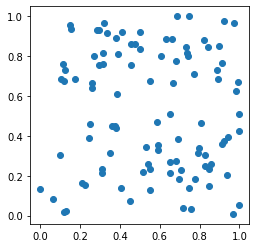

In [7]:
n = 100
data = np.random.uniform(0,1,(n,2))
fig1 = plt.scatter(data[:,0], data[:,1])
fig1.axes.set_aspect('equal')
X = torch.tensor(data, requires_grad=True)

In [8]:
# Compute H1 and H0
# maximum homology dimension is 1, which implies C_2 needed
layer = RipsLayer(maxdim = 1) 
# dgms = layer(X) # run FlagDiagram.forward()

In [9]:
f1 = BarcodePolyFeature(1,2,0)
optimizer = torch.optim.Adam([X], lr=1e-2)
for i in range(100):
    optimizer.zero_grad()
    # pass through AlphaLayer with PDs as outputs
    # then BarcodeFeatures layer
    loss = -f1(layer(X)) 
    loss.backward()
    optimizer.step()

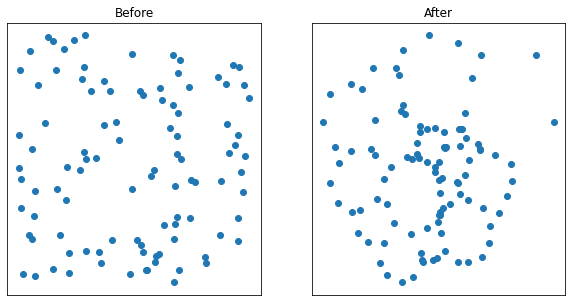

In [14]:
# save figure
y = X.detach().numpy()
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title("Before")
ax[1].scatter(y[:,0], y[:,1])
ax[1].set_title("After")
for i in range(2):
    # ax[i].axis('off') # remove all edges
    # only remove axes scales
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(bottom=False, left=False)
plt.savefig('holes.png')

## Create a gif

In [11]:
# Draw gif
import os
import imageio

In [15]:
n = 100
data = np.random.uniform(0,1,(n,2))
X = torch.tensor(data, requires_grad=True)
layer = RipsLayer(maxdim = 1) 
f1 = BarcodePolyFeature(1,2,0)
optimizer = torch.optim.Adam([X], lr=1e-2)

filenames = []
for index in range(200):
    optimizer.zero_grad()
    # pass through AlphaLayer with PDs as outputs
    # then BarcodeFeatures layer
    loss = -f1(layer(X)) 
    loss.backward()
    optimizer.step()
    y = X.detach().numpy()
    fig1 = plt.scatter(y[:,0], y[:,1])
    fig1.axes.set_aspect('equal')
    plt.axis('off')
    filename = f'images/frame_{index}.png'
    filenames.append(filename)
    # save img
    plt.savefig(filename, dpi=120)
    plt.close()

# Build GIF
print('creating gif\n')

gif_name = 'movie'
with imageio.get_writer(f'{gif_name}.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('gif complete\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('done')

creating gif

gif complete

Removing Images

done


# TODO
- Using Update/compression/clearing Algorithm in BATS